In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from modules.representation_schemes import enc1d_features, get_PTR_features, get_vectorized_featues, properties_from_comp
from modules.model_select import get_scoring_dict, model_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
hardness_df_loc = 'dataset/hardness.csv'
hardness_df = pd.read_csv(hardness_df_loc)
comps = hardness_df['Composition'].values
y = hardness_df['HV'].values
samples_per_bin, bins, = np.histogram(hardness_df['HV'], bins=np.arange(100,1000,100))    # Doane's method worked best for me
min_bin_size = samples_per_bin.min()
# compute the maximum batch size possible, using all samples from the bin with lowest population
n_bins = len(samples_per_bin)
hardness_df['bin_name'] = np.digitize(hardness_df['HV'].values,bins)

## Explaining different variances

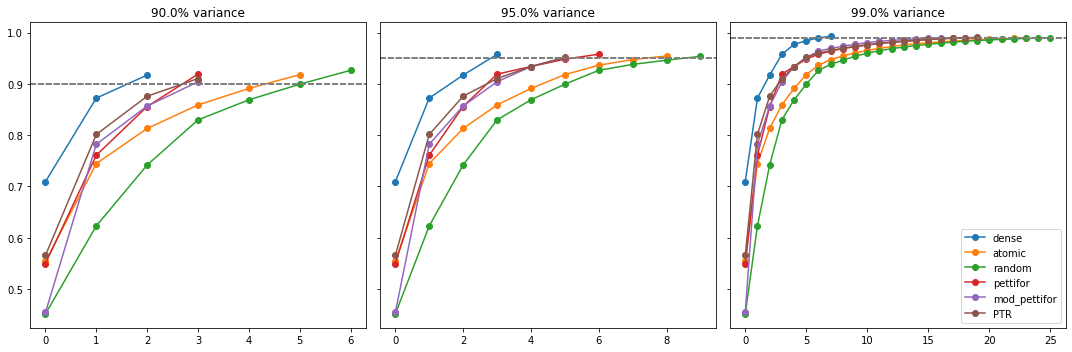

In [11]:
np.random.seed(0)
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
fig, ax  = plt.subplots(1,3, sharey=True, sharex = False, figsize = (15,5))
ax = ax.ravel()
variance_levels = [0.90,0.95,0.99]
var_dict = {}
for j,v in enumerate(variance_levels):
    component_dict_var = {}
    for i, method in enumerate(methods):
        if method == 'atomic':
            extracted = enc1d_features(comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(comps,'random')
        elif method == 'pettifor':
            extracted = enc1d_features(comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(comps)
        elif method == 'dense':
            extracted = enc1d_features(comps,'dense')
        pca = PCA()
        features = pca.fit_transform(extracted)
        ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=v)
        ax[j].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o', label =method)
        ax[j].axhline(y=v, color='grey', linestyle='dashed')
        #ax[j].text(16, 0.8, f'{v*100}% cut-off', color = 'grey', fontsize=10)
        ax[j].set_title(f'{v*100}% variance',y=1)
        component_dict_var[method] = ind
        #pca_dict[method] = pca.explained_variance_ratio_.tolist()
    var_dict[v] = component_dict_var
#fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
#fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.legend()
with open('misc/pca_results_hardness.pkl','wb') as fid:
    pickle.dump(var_dict,fid)

In [54]:
np.random.seed(0)
component_dict = var_dict[0.95]
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    pipelines, scoring_dict = model_pipeline(), get_scoring_dict()
    #X_train, X_test, y_train, y_test = train_test_split(features, y.ravel(), test_size=0.20,random_state = 0,stratify=hardness_df['bin_name'])
    rmse = {'train':[],'test':[]}
    r = {'train':[],'test':[]}
    train_rmse_results = []
    train_r_results = []
    test_rmse_results = []
    test_r_results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=10, random_state=21, shuffle=True)
        cv_results = cross_validate(model, features, y, cv=kfold, scoring=scoring_dict,return_train_score=True)
        rmse['train'].append(list(cv_results['train_rmse']))
        r['train'].append(list(cv_results['train_r']))
        rmse['test'].append(list(cv_results['test_rmse']))
        r['test'].append(list(cv_results['test_r']))
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results['test_r'].mean(), cv_results['test_r'].std())
        print(msg)
    method_dict[method] = {'rmse':rmse,'r':r}
save_loc = 'results/model_selection_hardness.json'
with open(save_loc,'w') as fid:
    json.dump(method_dict,fid)


atomic
Linear: 0.885542 (0.040111)
Lasso: 0.885616 (0.040456)
Ridge: 0.885551 (0.040118)
KNeighbor: 0.914754 (0.040737)
GBR: 0.919442 (0.020897)
RF: 0.923758 (0.026897)
XGB: 0.916365 (0.028541)
SVR-lin: 0.884450 (0.038084)
SVR-poly: 0.598012 (0.160392)
SVR-rbf: 0.855095 (0.038380)
MLP: 0.781779 (0.087584)
random
Linear: 0.854535 (0.036852)
Lasso: 0.854932 (0.037012)
Ridge: 0.854543 (0.036852)
KNeighbor: 0.909870 (0.033006)
GBR: 0.917717 (0.034266)
RF: 0.928166 (0.017113)
XGB: 0.920868 (0.040493)
SVR-lin: 0.853505 (0.036326)
SVR-poly: 0.514747 (0.131489)
SVR-rbf: 0.826017 (0.041655)
MLP: 0.711520 (0.084492)
pettifor
Linear: 0.866074 (0.035287)
Lasso: 0.865975 (0.035602)
Ridge: 0.866083 (0.035292)
KNeighbor: 0.904036 (0.037368)
GBR: 0.901865 (0.046337)
RF: 0.908130 (0.037389)
XGB: 0.907627 (0.039142)
SVR-lin: 0.865660 (0.038254)
SVR-poly: 0.634256 (0.071830)
SVR-rbf: 0.823513 (0.042263)
MLP: 0.794272 (0.042622)
mod_pettifor
Linear: 0.877162 (0.040344)
Lasso: 0.877284 (0.040170)
Ridge: 0.

In [9]:
def get_metrics(pipelines):
    metric_list = []
    for i in range(len(pipelines)):
       metric_list.append(pipelines[i][0])
    return metric_list

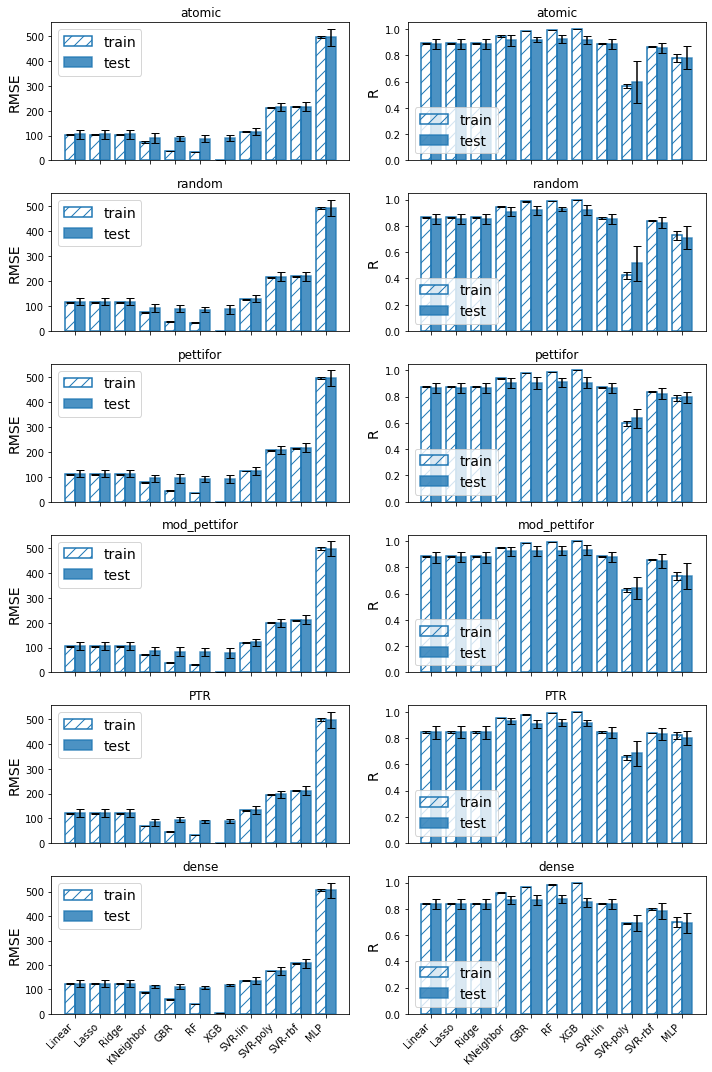

In [55]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
metrics = get_metrics(pipelines)
scores= ['rmse','r']
fig, ax = plt.subplots(len(methods),2,figsize=(10,15), sharex=True)
#ax = ax.flatten()
for m,method in enumerate(methods):
    for i in range(len(scores)):
        metric = scores[i]
        rmse = method_dict[method]['rmse']
        r = method_dict[method]['r']
        for k, key in enumerate(['train','test']):
            if key == 'train':
                mf = 'none'
                h = '//'
                a = 1.0
            else:
                mf = 'tab:blue'
                h = ''
                a = 0.8
            if metric == 'rmse':
                avg = -np.mean(rmse[key],axis=1)
                std = np.std(rmse[key],axis=1)
            elif metric == 'r':
                avg = np.mean(r[key],axis=1)
                std = np.std(r[key],axis=1)
            ax[m,i].bar(np.arange(len(metrics))+0.2*(2*k-1),avg,yerr = std,facecolor=mf, alpha=a, hatch=h, 
            width=0.40, color='tab:blue', edgecolor='tab:blue', linewidth=1.5, capsize=4,label=key)
            ax[m,i].set_xticks(np.arange(len(metrics)))
            ax[m,i].set_xticklabels(metrics, rotation=45, ha='right')
            ax[m,i].legend(fontsize=14)
            if metric == 'rmse':
                #ax.set_ylim(0, 5)
                ax[m,i].set_ylabel('RMSE',fontsize=14)
            elif metric == 'r':
                #ax.set_ylim(0, 1.01)
                ax[m,i].set_ylabel('R',fontsize=14)
            ax[m,i].set_title(method,y=1)
fig.tight_layout()

#plt.savefig('comp_vec_models.pdf')

Using RandomForest as model

In [31]:
#fixed folds
np.random.seed(0)
kf = KFold(n_splits=10, shuffle=True, random_state = 0)

In [56]:
methods = ['atomic','random','pettifor','mod_pettifor','PTR','dense']
method_dict = {}
component_dict = var_dict[0.95]
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    #gridCV = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,cv=10)
    pipe= Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])
    rmse = {'train':[],'test':[]}
    r = {'train':[],'test':[]}
    for k, (train, test) in enumerate(kf.split(features)):
        cv_results = cross_validate(pipe, features, y, cv=kfold, scoring=scoring_dict,return_train_score=True)
        rmse['train'].append(list(cv_results['train_rmse']))
        r['train'].append(list(cv_results['train_r']))
        rmse['test'].append(list(cv_results['test_rmse']))
        r['test'].append(list(cv_results['test_r']))
    method_dict[method] = {'rmse':rmse,'r':r}

atomic
random
pettifor
mod_pettifor
PTR
dense


In [46]:
np.mean(method_dict['pettifor']['r']['test']),np.mean(method_dict['PTR']['r']['test']),np.mean(method_dict['atomic']['r']['test']),np.mean(method_dict['dense']['r']['test'])

(0.8707558294802271, 0.872360521910257, 0.9065321294217219, 0.8456515286722501)

In [47]:
np.mean(method_dict['mod_pettifor']['r']['test']), np.mean(method_dict['random']['r']['test'])

(0.917924376349372, 0.87249317863557)

In [48]:
periodic_table_file = 'dataset/periodic_table.csv'
periodic_df = pd.read_csv(periodic_table_file)
atomic_number_order = periodic_df['Symbol'].values[:103]